# Repeat until success

## Background

This tutorial demonstrates the current capabilities of IBM dynamic-circuit backends to use mid-circuit measurements to produce a circuit that repeatedly attempts its setup until a syndrome measurement reveals that it has been successful.

We will build an abstract circuit that uses the non-parametrized gate set $\{H,\,X,\,S,\,\text{Toffoli}\}$ to construct a heralded $R_X(\theta)$ gate on a target qubit, where $\theta$ satisfies $\cos\theta = \frac35$. Each iteration of the circuit only has a finite chance of success, but successes are heralded, so we will use our dynamic-circuit capabilities to repeat the setup until it succeeds.

## Setup

In [1]:
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

# Qiskit Aer (Simulator)
from qiskit_aer import AerSimulator

# Qiskit IBM Provider
from qiskit_ibm_provider import IBMProvider, least_busy

In [2]:
provider = IBMProvider()
backend = least_busy(provider.backends(simulator=False, operational=True))
backend

<IBMBackend('ibm_rensselaer')>

## Build problem

A single trial of the probabalistic gate has the following form:

In [3]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

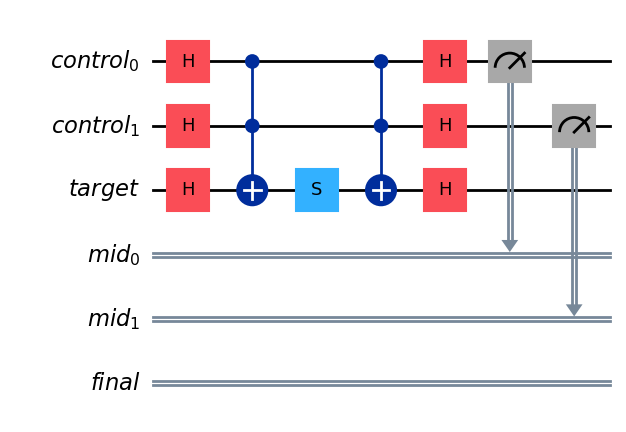

In [4]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

If _both_ measurements of the control bits return $0$, the applied gate is $R_X(\theta)$ with $\cos\theta = \frac35$.  If any of the measurements are $1$, then the applied gate is simply $X$, which is a failure.  This is our heralding; we can tell from the measurement whether we applied the correct gate, without disturbing the coherence of the target qubit.  Without fully reproducing the mathematics, the success probability of this gate is:
$$
P_{\text{success}} = \frac{
{|3 + i|}^2
}
{
{|3 + i|}^2 + 3{|1 - i|}^2
}
= \frac58
$$

If there is a failure, we should reset the dirty state, and start again.  Since we know what is applied in the case of a failure, we can use this knowledge to perform the reset efficiently, without using a general hardware reset.  For the two auxiliary qubits, this is just an $X$ gate conditioned on its respective measurement being $1$.  IBM hardware has a special fast-path for when qubits are conditioned on the result of their own measurement, so this is more efficient than most control flow.

In [5]:
def reset_controls(circuit, controls,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

Qiskit cannot directly represent an _inequality_ condition, which is what we require. We only need to do the repeat if the mid-circuit measurement result was not the bitstring `"00"`.  Instead, we can create an `if` statement with the condition `mid_measure == "00"`, pass an empty block, and then use the `else` branch to perform the logic we want.

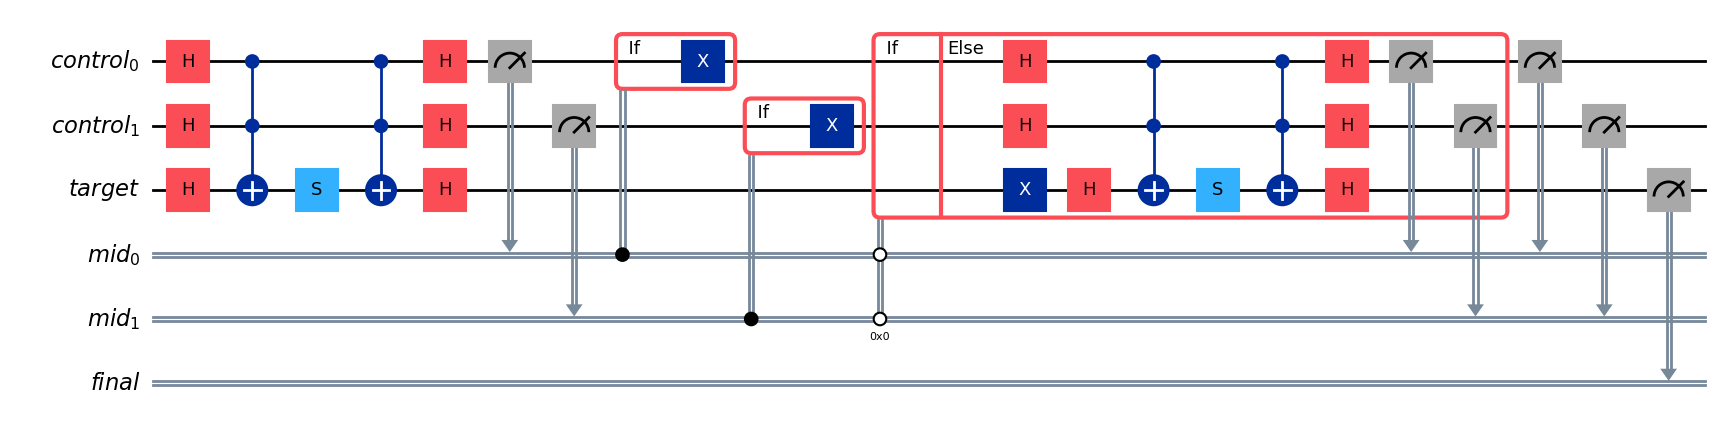

In [6]:
max_trials = 2

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        # First reset the target.
        circuit.x(target)
        # Then repeat the trial.
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw(output="mpl", style='iqp', cregbundle=False)

## Optimize the circuits

To prepare the circuit to run on real hardware, we use Qiskit's `transpile` function. By not specifying an `optimization_level` argument to `transpile`, we implicitly use level 1, which has light quantum optimization. For now, levels 2 and 3 do not support the dynamic circuits path as some of the optimizations used at those levels are not fully control-flow-aware.

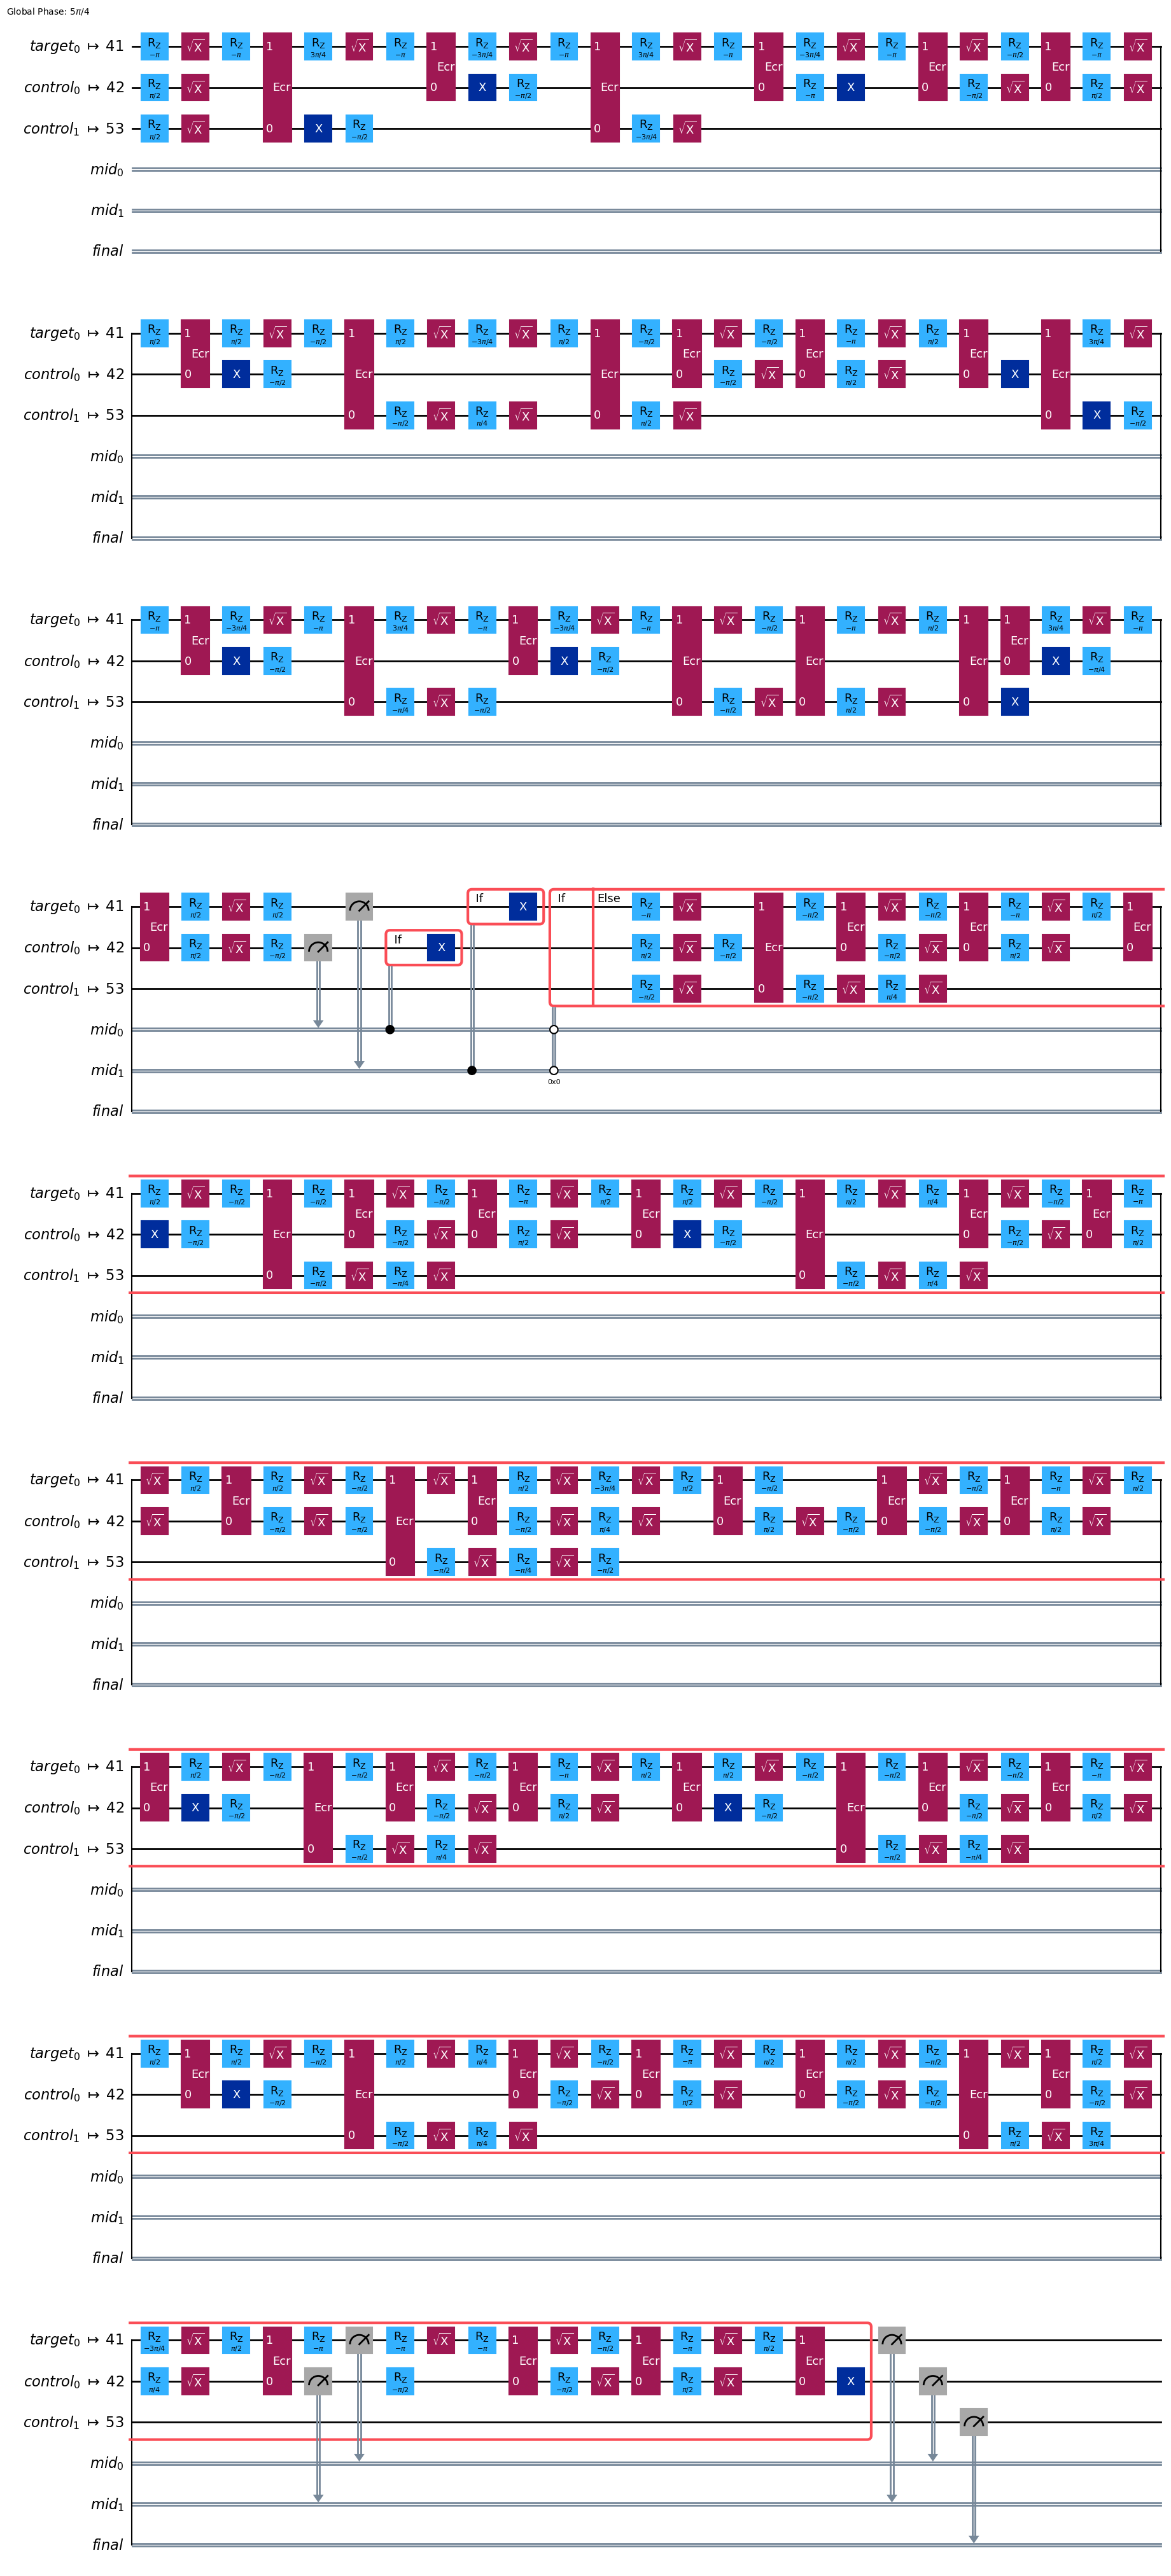

In [7]:
built = transpile(circuit, backend)
built.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

## Run on a simulator

In [8]:
sim = AerSimulator().from_backend(backend)
simulator_result = sim.run(built).result()
simulator_counts = simulator_result.get_counts()
simulator_counts

{'1 11': 94,
 '0 11': 89,
 '0 01': 79,
 '1 00': 224,
 '1 10': 90,
 '1 01': 115,
 '0 10': 109,
 '0 00': 224}

## Run on IBM hardware

In [9]:
job = backend.run(built, dynamic=True)
job.job_id()

'cq58wbh7z1hg008fjfh0'

In [10]:
hardware_counts = job.result().get_counts()
hardware_counts

{'0 00': 1580,
 '0 01': 226,
 '0 10': 198,
 '0 11': 339,
 '1 00': 995,
 '1 01': 228,
 '1 10': 156,
 '1 11': 278}

## Analyze the results

A successful result is one in which the measurements on the two controls end in the `00` state.  Let's filter those out, and see how many successes will result.  This is a type of post-selection.  In the complete repeat-until-success circuit, with a dynamic `while` loop, we would not need this, as we would be guaranteed a success.  However, in the interim, we can use the probabilities to examine the quality of the output, and verify that the probabilities are what we expect.

In [11]:
import collections

def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)

    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value

    return successes, failures

In [12]:
hw_successes, hw_failures = marginalize_successes(hardware_counts)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(hardware_counts.values())
print(f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}.")

Expected success rate 0.859.  Actual rate 0.644.


We can also test the post-selected output state:

In [13]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.386.


In [14]:
import qiskit_ibm_provider

qiskit_ibm_provider.version.get_version_info()

'0.9.0'

In [15]:
import qiskit

qiskit.version.get_version_info()

'1.0.0rc1'